In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import time
import random
import matplotlib.pyplot as plt
import math
import glob
from torch import Tensor
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pack_sequence,pad_packed_sequence
from data_processing import get_data, get_sources_targets_short, get_source_target, get_speed_short, get_with_speed




In [2]:
def scaled_dot_product_attention(query: Tensor, key: Tensor, value: Tensor) -> Tensor:
    temp = query.bmm(key.transpose(1, 2))
    scale = query.size(-1) ** 0.5
    softmax = F.softmax(temp / scale, dim=-1)
    return softmax.bmm(value)

In [3]:
class AttentionHead(nn.Module):
    def __init__(self, dim_in: int, dim_q: int, dim_k: int):
        super().__init__()
        self.q = nn.Linear(dim_in, dim_q)
        self.k = nn.Linear(dim_in, dim_k)
        self.v = nn.Linear(dim_in, dim_k)

    def forward(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
        
        return scaled_dot_product_attention(self.q(query), self.k(key), self.v(value))

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, dim_in: int, dim_q: int, dim_k: int):
        super().__init__()
        self.heads = nn.ModuleList(
            [AttentionHead(dim_in, dim_q, dim_k) for _ in range(num_heads)]
        )
        self.linear = nn.Linear(num_heads * dim_k, dim_in)

    def forward(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
        
        return self.linear(
            torch.cat([h(query, key, value) for h in self.heads], dim=-1)
        )

In [5]:
def position_encoding(
    seq_len: int, dim_model: int, device: torch.device = torch.device("cpu"),
) -> Tensor:
    pos = torch.arange(seq_len, dtype=torch.float, device=device).reshape(1, -1, 1)
    dim = torch.arange(dim_model, dtype=torch.float, device=device).reshape(1, 1, -1)
    phase = pos / (1e4 ** (dim // dim_model))

    return torch.where(dim.long() % 2 == 0, torch.sin(phase), torch.cos(phase))

In [6]:
def feed_forward(dim_input: int = 512, dim_feedforward: int = 2048) -> nn.Module:
    return nn.Sequential(
        nn.Linear(dim_input, dim_feedforward),
        nn.ReLU(),
        nn.Linear(dim_feedforward, dim_input),
    )

In [7]:
class Residual(nn.Module):
    def __init__(self, sublayer: nn.Module, dimension: int, dropout: float = 0.1):
        super().__init__()
        self.sublayer = sublayer
        self.norm = nn.LayerNorm(dimension)
        self.dropout = nn.Dropout(dropout)

    def forward(self, *tensors: Tensor) -> Tensor:
        # Assume that the "query" tensor is given first, so we can compute the
        # residual.  This matches the signature of 'MultiHeadAttention'.
        return self.norm(tensors[0] + self.dropout(self.sublayer(*tensors)))

In [8]:
class TransformerEncoderLayer(nn.Module):
    def __init__(
        self,
        dim_model: int = 512,
        num_heads: int = 3,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
    ):
        super().__init__()
        dim_q = dim_k = max(dim_model // num_heads, 1)
        self.attention = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
            dimension=dim_model,
            dropout=dropout,
        )
        self.feed_forward = Residual(
            feed_forward(dim_model, dim_feedforward),
            dimension=dim_model,
            dropout=dropout,
        )

    def forward(self, src: Tensor) -> Tensor:
        src = self.attention(src, src, src)
        return self.feed_forward(src)


class TransformerEncoder(nn.Module):
    def __init__(
        self,
        input_size: int = 4,
        num_layers: int = 3,
        dim_model: int = 512,
        num_heads: int = 3,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TransformerEncoderLayer(dim_model, num_heads, dim_feedforward, dropout)
                for _ in range(num_layers)
            ]
        )
        self.linear_in = nn.Linear(input_size, dim_model)
        

    def forward(self, src: Tensor) -> Tensor:
        embedded = self.linear_in(src)
        seq_len, dimension = embedded.size(1), embedded.size(2)
        
        embedded += position_encoding(seq_len, dimension)
        for layer in self.layers:
            embedded = layer(embedded)
        
        return embedded


In [9]:
class TransformerDecoderLayer(nn.Module):
    def __init__(
        self,
        dim_model: int = 512,
        num_heads: int = 3,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
    ):
        super().__init__()
        dim_q = dim_k = max(dim_model // num_heads, 1)
       
        self.attention = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
            dimension=dim_model,
            dropout=dropout,
        )
        self.feed_forward = Residual(
            feed_forward(dim_model, dim_feedforward),
            dimension=dim_model,
            dropout=dropout,
        )

    def forward(self, tgt: Tensor, memory: Tensor) -> Tensor:
       
        
        tgt = self.attention(tgt, memory, memory)
        return self.feed_forward(tgt)


class TransformerDecoder(nn.Module):
    def __init__(
        self,
        output_size: int = 4,
        num_layers: int = 3,
        dim_model: int = 512,
        num_heads: int = 8,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.output_size = output_size
        self.layers = nn.ModuleList(
            [
                TransformerDecoderLayer(dim_model, num_heads, dim_feedforward, dropout)
                for _ in range(num_layers)
            ]
        )
        
       
        self.linear_out = nn.Linear(dim_model, output_size)
        
    def forward(self, tgt: Tensor, memory: Tensor) -> Tensor:
        for layer in self.layers:
            tgt = layer(tgt, memory) #[20, 500, 512], [20. 1100.512]=> [20, 500, 512]
        
        outputs = self.linear_out(tgt).view(num_target, tgt.shape[0], -1, self.output_size)
        
        
        return outputs.permute(1, 2, 0, 3)  #11, 20, 100, 2=>20,100,11,2

In [10]:
class Transformer(nn.Module):
    def __init__(
        self, 
        num_encoder_layers: int = 6,
        num_decoder_layers: int = 6,
        dim_model: int = 512, 
        num_heads: int = 3, 
        dim_feedforward: int = 2048, 
        dropout: float = 0.1, 
        activation: nn.Module = nn.ReLU(),
    ):
        super().__init__()
        self.encoder = TransformerEncoder(
            num_layers=num_encoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.decoder = TransformerDecoder(
            num_layers=num_decoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )

    
    def forward(self, src: Tensor) -> Tensor:
       
        src_permute = src.permute(2, 0, 1, 3) #20, 100  11, 2=> 11, 20, 100, 2
        temp = []
        tgt_src = []
        
        for i, each_src in enumerate(src_permute):
            enc = self.encoder(each_src)
            temp.append(enc)  # 11 of #encoder[20, 100, 2]=>[20, 100, 512]
            if (i < num_target):
                tgt_src.append(enc)
                
        total_enc = torch.cat(temp, dim = 1)  #20, 100*11, 512
        tgt = torch.cat(tgt_src, dim = 1)  #20, 100*5, 512
        return self.decoder(tgt, total_enc)


In [11]:
# produce dataset
class MyDataset(Dataset):
    def __init__(self,data):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        super().__init__()
        self.data = data
        

    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        
        return self.data[index]
        
    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.data)



In [12]:
path = './data'
df = pd.concat(map(pd.read_csv, glob.glob(path + "/*.csv")))
# path = 'D:/VRE_project/nba-movement-data/data/csv/0021500001.csv'
# df = pd.read_csv(path)
game_data, flag_index = get_data(df)
print(game_data[0], flag_index[:5])

[53.11965 27.65268] [    0  5621 11154 12562 13750]


In [13]:
source_ordinal = 0
num_source = 11
target_ordinal = 1
num_target = 3
sources, targets = get_sources_targets_short(game_data, flag_index, 15)
s_speeds, t_speeds = get_speed_short(game_data, flag_index, 15)
# source, target = get_source_target(sources, targets, source_ordinal,num_source,target_ordinal,num_target)
source, target =get_with_speed(sources,s_speeds, source_ordinal,num_source,targets, t_speeds, target_ordinal,num_target )



In [14]:
print(len(source), source[0][0].shape)

2394 torch.Size([11, 4])


In [15]:
BATCH_SIZE = 20
total = []
for i in range(len(source)):
    temp = (source[i], target[i])
    total.append(temp)
example = []
for i in range(BATCH_SIZE):
    temp = (source[i], target[i])
    example.append(temp)

In [16]:
total_data = MyDataset(total)
ex_data =MyDataset(example)
train_size = int(len(total_data) * 0.7)
val_size = int(len(total_data)*0.2)
test_size = len(total_data) - train_size - val_size
train_data,val_data, test_data =random_split(total_data, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last = True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last = True)
ex_loader = DataLoader(ex_data, batch_size=BATCH_SIZE, shuffle=False, drop_last = False)


In [17]:
print(iter(train_loader).__next__()[0].shape,iter(train_loader).__next__()[1].shape )
print(iter(ex_loader).__next__()[0].shape,iter(ex_loader).__next__()[1].shape )

torch.Size([20, 15, 11, 4]) torch.Size([20, 15, 3, 4])
torch.Size([20, 15, 11, 4]) torch.Size([20, 15, 3, 4])


In [18]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Transformer().to(dev)


In [19]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, (x, y) in enumerate(dataloader):
        # put data into GPU
        x = x.to(dev)
        y = y.to(dev)
        
        # zero all param gradients
        optimizer.zero_grad()
        
        # run attetion_encoding to get predictions
        y_pred = model(x)
        
        # get loss and compute model trainable params gradients though backpropagation
        loss = criterion(y_pred, y)
        loss.backward()
        
        # update model params
        optimizer.step()
        
        # add batch loss, since loss is single item tensor
        # we can get its value by loss.item()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(dev)
            y = y.to(dev)
            
            # turn off teacher forcing
            y_pred = model(x)
            
            loss = criterion(y_pred, y)
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)



In [20]:
N_EPOCHES = 20
best_val_loss = float('inf')
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [21]:
%load_ext tensorboard
writer = SummaryWriter()

In [ ]:
# load previous best model params if exists
model_dir = "saved_models/tranformer"
saved_model_path = model_dir + "/best_transformer_11_3_speed.pt"
# if os.path.isfile(saved_model_path):
#     model.load_state_dict(torch.load(saved_model_path))
#     print("successfully load previous best model parameters")
    
for epoch in range(N_EPOCHES):
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)
   
    end_time = time.time()
    
    secs = end_time - start_time
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss,epoch)
   
    print(F'Epoch: {epoch+1:02} | Time:  {secs}s')
    print(F'\tTrain Loss: {train_loss:.3f}')
    print(F'\t Val. Loss: {val_loss:.3f}')

    if val_loss < best_val_loss:
        os.makedirs(model_dir, exist_ok=True)
        torch.save(model.state_dict(), saved_model_path)
writer.close()

<ipython-input-5-ebea6724ae9b>:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  phase = pos / (1e4 ** (dim // dim_model))


Epoch: 01 | Time:  529.0858864784241s
	Train Loss: 250.520
	 Val. Loss: 217.321
Epoch: 02 | Time:  531.924756526947s
	Train Loss: 219.035
	 Val. Loss: 257.165
Epoch: 03 | Time:  525.7669937610626s
	Train Loss: 220.906
	 Val. Loss: 216.130


In [23]:

test_loss = evaluate(model, test_loader, criterion)
print(f'| Test Loss: {test_loss:.3f} ')
# | Test PPL: {math.exp(round(test_loss, 3)):7.3f} |

<ipython-input-5-ebea6724ae9b>:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  phase = pos / (1e4 ** (dim // dim_model))


| Test Loss: 214.952 


<ipython-input-5-ebea6724ae9b>:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  phase = pos / (1e4 ** (dim // dim_model))


<Figure size 432x288 with 0 Axes>

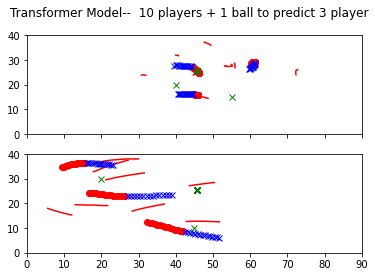

In [34]:
scenes = 2
plt.clf()
fig, axs = plt.subplots(scenes,sharex=True, sharey=True )
plt.axis([0, 90, 0, 40])
fig.suptitle('Transformer Model--  10 players + 1 ball to predict 3 player')
p, q = iter(ex_loader).__next__()  # p [20, 15, 11, 4] q [20, 15, 3, 4]
r = model(p).detach()  #r [20, 15, 3, 4]
p_= p.permute(0, 2, 1, 3) #20, 11, 15, 4
q_= q.permute(0, 2, 1, 3) 
r_= r.permute(0, 2, 1, 3)
for j in range(scenes):
    for i in range(len(p_[j])):
        if (i >= target_ordinal and i < target_ordinal + num_target):
            axs[j].plot(p_[j][i][:, 0], p_[j][i][:, 1], 'ro', linewidth=0.5, label = "source")
          
        axs[j].plot(p_[j][i][:, 0], p_[j][i][:, 1], color = "red", label ="ref", )
    for i in range(len(q_[j])):
        axs[j].plot(q_[j][i][:, 0], q_[j][i][:, 1], "bx", linewidth = 0.2, label = "target")
        axs[j].plot(r_[j][i][:, 0], r_[j][i][:, 1], "gx", linewidth = 0.2, label = "predict")

plt.show()

In [ ]:
!tensorboard --logdir=runs